e:\sih code\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processed Frame 0 - Features Shape: torch.Size([197, 768])
Processed Frame 1 - Features Shape: torch.Size([197, 768])
Processed Frame 2 - Features Shape: torch.Size([197, 768])
Processed Frame 3 - Features Shape: torch.Size([197, 768])
Processed Frame 8 - Features Shape: torch.Size([197, 768])
Processed Frame 9 - Features Shape: torch.Size([197, 768])
Processed Frame 10 - Features Shape: torch.Size([197, 768])
Processed Frame 11 - Features Shape: torch.Size([197, 768])
Processed Frame 12 - Features Shape: torch.Size([197, 768])
Processed Frame 13 - Features Shape: torch.Size([197, 768])
Processed Frame 14 - Features Shape: torch.Size([197, 768])
Processed Frame 15 - Features Shape: torch.Size([197, 768])
Processed Frame 16 - Features Shape: torch.Size([197, 768])
Processed Frame 17 - Features Shape: torch.Size([197, 768])
Processed Frame 18 - Features Shape: torch.Size([197, 768])
Processed Frame 19 - Features Shape: torch.Size([197, 768])
Processed Frame 20 - Features Shape: torch.Siz

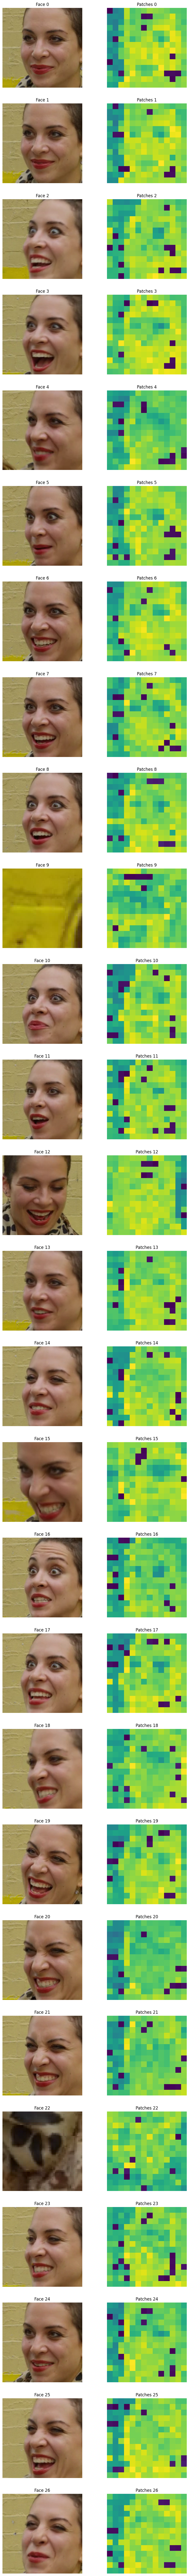

In [4]:
import pickle
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from transformers import ViTImageProcessor, ViTModel
import traceback

# Add the path to your cloned StyleGAN2-ADA repo
sys.path.append('E:\\sih code\\stylegan2-ada-pytorch')  # Adjust this path

# Function to load the combined model
def load_combined_model(model_path):
    try:
        with open(model_path, 'rb') as f:
            combined_model = pickle.load(f)
        return combined_model
    except FileNotFoundError:
        print(f"Error: The file {model_path} does not exist.")
        sys.exit(1)
    except Exception as e:
        print(f"Error loading model: {e}")
        sys.exit(1)

# Load the StyleGAN2-ADA combined model
model_path = 'E:\\sih code\\stylegan2-ffhq-1024x1024.pkl'  # Adjust the path to your model file
combined_model = load_combined_model(model_path)

# Access the generator and discriminator
try:
    generator = combined_model.get('G_ema', None)  # Adjust based on your model's structure
    discriminator = combined_model.get('D', None)  # Adjust based on your model's structure

    if generator is None or discriminator is None:
        raise AttributeError("Generator or discriminator not found in the loaded model.")
except AttributeError as e:
    print(f"Error: {e}")
    sys.exit(1)

# Initialize the Vision Transformer with the Image Processor
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Load Haar cascade classifier for face detection
haar_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

# Open the video file
video_path = r"E:\\deep fake dataset\\DFD_original sequences\\01__hugging_happy.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get the frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
interval = int(fps)  # Set the interval to capture 1 frame per second

frames = []  # To store captured frames
patches_images = []  # To store patch images
face_crops = []  # To store face crops

frame_count = 0
sec_count = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # If the frame was not read successfully, break the loop
    if not ret:
        break

    # Process only 1 frame per second
    if frame_count % interval == 0:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB for ViT
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for face detection

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # If faces are detected, crop and process the first detected face
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face_crop = frame_rgb[y:y+h, x:x+w]  # Crop the face from the frame
            face_crops.append(face_crop)  # Store the cropped face for display and feature extraction

            # Prepare the cropped face for the Vision Transformer
            inputs = image_processor(images=face_crop, return_tensors="pt")

            # Extract features
            with torch.no_grad():
                outputs = vit_model(**inputs)

            # Access the last hidden state (features of each patch)
            features = outputs.last_hidden_state.squeeze(0)  # Remove batch dimension

            # Reshape and store the patch images (16x16 patches)
            patch_features = features[1:, :].mean(dim=1).detach().numpy()  # Exclude CLS token and take mean for each patch
            num_patches = int(np.sqrt(patch_features.shape[0]))
            patch_image = patch_features.reshape(num_patches, num_patches)  # Reshape into 16x16

            patches_images.append(patch_image)  # Store patch image for display

            print(f"Processed Frame {sec_count} - Features Shape: {features.shape}")

        sec_count += 1  # Increment second counter

    frame_count += 1

# Release the video capture object
cap.release()
cv2.destroyAllWindows()

# Display frames and corresponding patch images
num_frames = len(face_crops)
cols = min(num_frames, 2)  # Display 2 columns: original face crop and patch image
rows = num_frames

fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))

for i in range(num_frames):
    # Show original face crop
    axes[i, 0].imshow(face_crops[i])
    axes[i, 0].set_title(f"Face {i}")
    axes[i, 0].axis('off')

    # Show patch image
    axes[i, 1].imshow(patches_images[i], cmap='viridis')
    axes[i, 1].set_title(f"Patches {i}")
    axes[i, 1].axis('off')





In [3]:
combined_model

{'G': Generator(
   (synthesis): SynthesisNetwork(
     w_dim=512, num_ws=18, img_resolution=1024, img_channels=3, num_fp16_res=4
     (b4): SynthesisBlock(
       resolution=4, architecture=skip
       (conv1): SynthesisLayer(
         in_channels=512, out_channels=512, w_dim=512, resolution=4, up=1, activation=lrelu
         (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
       )
       (torgb): ToRGBLayer(
         in_channels=512, out_channels=3, w_dim=512
         (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
       )
     )
     (b8): SynthesisBlock(
       resolution=8, architecture=skip
       (conv0): SynthesisLayer(
         in_channels=512, out_channels=512, w_dim=512, resolution=8, up=2, activation=lrelu
         (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
       )
       (conv1): SynthesisLayer(
         in_channels=512, out_channels=512, w_dim=512, resolution

In [1]:
def generate_fake_image(generator, latent_vector, condition_vector):
    device = next(generator.parameters()).device  # Get the device from the generator
    latent_vector = latent_vector.to(device)
    if condition_vector is not None:
        condition_vector = condition_vector.to(device)
    with torch.no_grad():
        fake_image = generator(latent_vector, condition_vector)  # Always pass the condition vector
    return fake_image

def visualize_fake_image(generator, latent_vector, condition_vector=None):
    fake_image = generate_fake_image(generator, latent_vector, condition_vector)
    
    # Convert the tensor to a NumPy array
    fake_image = fake_image.squeeze().cpu()  # Remove batch dimension and move to CPU
    fake_image_np = fake_image.permute(1, 2, 0).clamp(0, 1).numpy()  # Permute to HWC and convert to NumPy
    
    # Convert the NumPy array to a PIL Image
    fake_image_pil = Image.fromarray((fake_image_np * 255).astype(np.uint8))  # Scale to [0, 255] and convert to uint8
    
    # Display the image using Matplotlib
    plt.imshow(fake_image_pil)
    plt.title("Generated Fake Image")
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
latent_vector = torch.randn(1, generator.z_dim)  # Generate a random latent vector
condition_vector = torch.zeros(1, generator.c_dim) if hasattr(generator, 'c_dim') and generator.c_dim > 0 else None

visualize_fake_image(generator, latent_vector, condition_vector)




NameError: name 'torch' is not defined

In [14]:
import torch

print(torch.cuda.is_available())  # Should print True if GPU is available
print(torch.cuda.device_count())  # Number of GPUs available
 # Current device being used
  # Name of the first device (if available)


False
0


In [15]:
def calculate_accuracy(discriminator, real_features, fake_features):
    """
    Calculate the discriminator's accuracy in distinguishing real vs. fake features.
    
    Args:
        discriminator: The StyleGAN2 discriminator model.
        real_features: A tensor of features extracted from real images.
        fake_features: A tensor of features extracted from generated (fake) images.
    
    Returns:
        accuracy: The accuracy of the discriminator.
    """
    # Combine real and fake features
    features = torch.cat([real_features, fake_features], dim=0)
    labels = torch.cat([torch.ones(len(real_features)), torch.zeros(len(fake_features))])
    
    # Move to the appropriate device
    device = next(discriminator.parameters()).device
    features = features.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        try:
            # Inspect features shape
            print(f"Features shape before reshaping: {features.shape}")
            
            # StyleGAN2 discriminator might require features to be reshaped
            # Example: Reshape if features are flattened; Adjust dimensions as needed
            if len(features.shape) == 2:
                # Print the size for debugging
                print(f"Flattened features size: {features.size(1)}")
                
                # Example: Assuming features are flattened and need to be reshaped into (N, C, H, W)
                # You need to calculate the dimensions based on your specific model
                # Adjust the following line based on actual expected dimensions
                features = features.view(-1, 3, 64, 64)  # Adjust dimensions based on your model's requirements
            
            # Check if discriminator requires condition vector
            if hasattr(discriminator, 'c_dim') and discriminator.c_dim > 0:
                condition_vector = torch.zeros(features.size(0), discriminator.c_dim, device=device)
                outputs = discriminator(features, condition_vector)
            else:
                outputs = discriminator(features)
            
            # StyleGAN2 discriminator might return a tuple, get the first element
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            # Convert outputs to predictions (1 for real, 0 for fake)
            predictions = (outputs > 0).float().squeeze()
            
        except Exception as e:
            print(f"Error during discriminator forward pass: {e}")
            raise

    # Calculate accuracy
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy


In [16]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    # Extract real features
    real_features = []
    for face in face_crops:
        inputs = image_processor(images=face, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vit_model(**inputs)
        features = outputs.last_hidden_state.mean(dim=1)
        real_features.append(features)
    real_features = torch.cat(real_features, dim=0)
    
    # Generate fake images and extract features
    fake_features = []
    num_fakes = len(face_crops)
    for _ in range(num_fakes):
        latent = torch.randn(1, generator.z_dim, device=device)
        condition_vector = torch.zeros(1, generator.c_dim, device=device) if hasattr(generator, 'c_dim') and generator.c_dim > 0 else None
        fake_image = generate_fake_image(generator, latent, condition_vector)
        
        fake_image_np = (fake_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).squeeze().cpu().numpy()
        fake_image_pil = Image.fromarray(fake_image_np)
        
        inputs = image_processor(images=fake_image_pil, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vit_model(**inputs)
        features = outputs.last_hidden_state.mean(dim=1)
        fake_features.append(features)
    
    fake_features = torch.cat(fake_features, dim=0)
    
    # Calculate accuracy
    accuracy = calculate_accuracy(discriminator, real_features, fake_features)
    print(f"Discriminator Accuracy: {accuracy:.2f}")

except Exception as e:
    print(f"Error in accuracy calculation: {e}")
    traceback.print_exc()


Features shape before reshaping: torch.Size([54, 768])
Flattened features size: 768
Error during discriminator forward pass: shape '[-1, 3, 64, 64]' is invalid for input of size 41472
Error in accuracy calculation: shape '[-1, 3, 64, 64]' is invalid for input of size 41472


Traceback (most recent call last):
  File "C:\Users\nawfa\AppData\Local\Temp\ipykernel_15200\1796179287.py", line 35, in <module>
    accuracy = calculate_accuracy(discriminator, real_features, fake_features)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nawfa\AppData\Local\Temp\ipykernel_15200\3163036627.py", line 36, in calculate_accuracy
    features = features.view(-1, 3, 64, 64)  # Adjust dimensions based on your model's requirements
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: shape '[-1, 3, 64, 64]' is invalid for input of size 41472


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.2.2+cpu
None
False


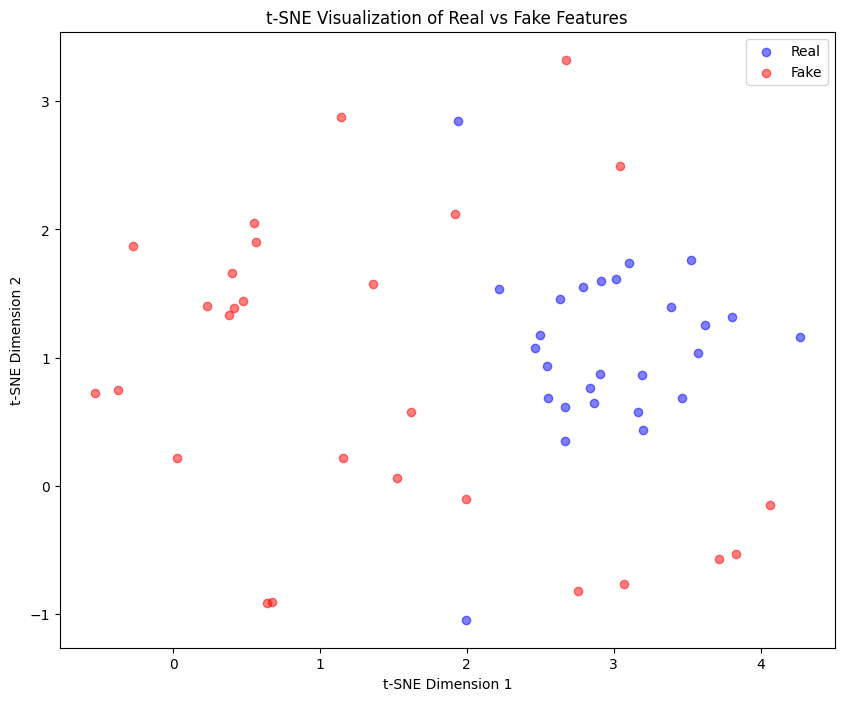

In [37]:

from sklearn.manifold import TSNE

def visualize_features(real_features, fake_features):
    # Combine real and fake features
    features = torch.cat([real_features, fake_features], dim=0)
    
    # Create labels for the features
    labels = torch.cat([torch.ones(len(real_features)), torch.zeros(len(fake_features))]).cpu().numpy()
    
    # Apply t-SNE
    features_np = features.cpu().numpy()  # Convert to numpy array
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features_np)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(features_tsne[labels == 1, 0], features_tsne[labels == 1, 1], color='blue', label='Real', alpha=0.5)
    plt.scatter(features_tsne[labels == 0, 0], features_tsne[labels == 0, 1], color='red', label='Fake', alpha=0.5)
    plt.title('t-SNE Visualization of Real vs Fake Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()

# Example usage
try:
    # Determine the device
    device = next(generator.parameters()).device
    
    # Extract real features
    real_features = []
    for face in face_crops:
        inputs = image_processor(images=face, return_tensors="pt")
        with torch.no_grad():
            outputs = vit_model(**inputs)
        features = outputs.last_hidden_state.mean(dim=1)  # Average over patches
        real_features.append(features)
    real_features = torch.cat(real_features, dim=0)
    
    # Generate fake images and extract features
    fake_features = []
    num_fakes = len(face_crops)
    for _ in range(num_fakes):
        # Generate a random latent vector
        latent = torch.randn(1, generator.z_dim, device=device)
        
        # Generate a fake image
        condition_vector = torch.zeros(1, generator.c_dim, device=device) if hasattr(generator, 'c_dim') and generator.c_dim > 0 else None
        fake_image = generate_fake_image(generator, latent, condition_vector)
        
        # Convert the fake image to numpy array and then to PIL Image
        fake_image_np = (fake_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).squeeze().cpu().numpy()
        fake_image_pil = Image.fromarray(fake_image_np)
        
        # Extract features from the fake image
        inputs = image_processor(images=fake_image_pil, return_tensors="pt")
        with torch.no_grad():
            outputs = vit_model(**inputs)
        features = outputs.last_hidden_state.mean(dim=1)  # Average over patches
        fake_features.append(features)
    fake_features = torch.cat(fake_features, dim=0)
    
    # Visualize
    visualize_features(real_features, fake_features)

except Exception as e:
    print(f"Error in feature extraction or visualization: {e}")
    traceback.print_exc()
